## Notebook For Collaborative Filtering Model Using the following Hybrid:

### Model 1. SVD (Singular Vector Decomposition) 

- Using Surprise as it will be more lightweight in deployment in Streamlit
- Initially tried doing on Matrix Factorization but it would not be as scalable due to heavy matrices; and the fact that this is a hybrid recommender model
- However, for academic purposes, I have also included my code using Matrix Factorization to attain SVD

### 2. Deep Neural Networks

- Solely for the purpose of trying out a Hybrid System as a stretch goal, which would also be lightweight enough for eventual deployment on Streamlit
- Motivation also lies in having a Neural Network Training Academic Project
- Unfortunately, Content-Based Recommender model is not possible due to the lack of metadata, to be then combined with Collaborative Filtering Recommender model

In [1]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as sklearn_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

DATA_FOLDER = 'dataset/'

# Load data
ratings_df = pd.read_table(f"{DATA_FOLDER}ratings.csv", sep=',')
movies_df = pd.read_table(f"{DATA_FOLDER}movies.csv", sep=',')

In [2]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [3]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [4]:
print(f"Original ratings shape: {ratings_df.shape}")
print(f"Original movies shape: {movies_df.shape}")

Original ratings shape: (100836, 4)
Original movies shape: (9742, 3)


## 1. Genre analysis of Full Dataset (100K)

In [5]:
print("\n=== GENRE ANALYSIS ===")
all_genres = set()
for genres_str in movies_df.genres:
    if pd.notna(genres_str):
        genres_list = genres_str.split('|')
        all_genres.update(genres_list)

print(f"Unique genres ({len(all_genres)}):")
for genre in sorted(all_genres):
    count = movies_df[movies_df.genres.str.contains(genre, na=False)].shape[0]
    print(f"  {genre}: {count} movies")


=== GENRE ANALYSIS ===
Unique genres (20):
  (no genres listed): 34 movies
  Action: 1828 movies
  Adventure: 1263 movies
  Animation: 611 movies
  Children: 664 movies
  Comedy: 3756 movies
  Crime: 1199 movies
  Documentary: 440 movies
  Drama: 4361 movies
  Fantasy: 779 movies
  Film-Noir: 87 movies
  Horror: 978 movies
  IMAX: 158 movies
  Musical: 334 movies
  Mystery: 573 movies
  Romance: 1596 movies
  Sci-Fi: 980 movies
  Thriller: 1894 movies
  War: 382 movies
  Western: 167 movies


## 2. Exploratory Data Analysis

In [6]:
print(f"Total users: {ratings_df.userId.nunique()}")
print(f"Total movies: {ratings_df.movieId.nunique()}")
print(f"Total ratings: {len(ratings_df)}")
print(f"Sparsity: {(1 - len(ratings_df) / (ratings_df.userId.nunique() * ratings_df.movieId.nunique())) * 100:.2f}%")

user_rating_counts = ratings_df.groupby('userId').size()
movie_rating_counts = ratings_df.groupby('movieId').size()
print(f"Average ratings per user: {user_rating_counts.mean():.1f}")
print(f"Average ratings per movie: {movie_rating_counts.mean():.1f}")

Total users: 610
Total movies: 9724
Total ratings: 100836
Sparsity: 98.30%
Average ratings per user: 165.3
Average ratings per movie: 10.4


## 3. Data Preparation for SVD and NN

In [7]:
# For Surprise SVD
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
trainset_surprise, testset_surprise = train_test_split(surprise_data, test_size=0.2, random_state=42)

In [8]:
# For Neural Network - encode users and movies
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings_encoded = ratings_df.copy()
ratings_encoded['user_encoded'] = user_encoder.fit_transform(ratings_df['userId'])
ratings_encoded['movie_encoded'] = movie_encoder.fit_transform(ratings_df['movieId'])

# Split data for neural network
X = ratings_encoded[['user_encoded', 'movie_encoded']].values
y = ratings_encoded['rating'].values

X_train, X_test, y_train, y_test = sklearn_split(X, y, test_size=0.2, random_state=42)

n_users = ratings_df.userId.nunique()
n_movies = ratings_df.movieId.nunique()

print(f"Encoded users: {n_users}")
print(f"Encoded movies: {n_movies}")
print(f"Neural Network training samples: {len(X_train)}")
print(f"Neural Network test samples: {len(X_test)}")

Encoded users: 610
Encoded movies: 9724
Neural Network training samples: 80668
Neural Network test samples: 20168


## 4. Hyperparameter Optimization for SVD

In [9]:
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.05]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(surprise_data)

print(f"Best SVD RMSE: {gs.best_score['rmse']:.4f}")
print(f"Best SVD parameters: {gs.best_params['rmse']}")

Best SVD RMSE: 0.8663
Best SVD parameters: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.05}


In [10]:
best_svd = gs.best_estimator['rmse']
best_svd.fit(trainset_surprise)

## 5. Collaborative Filtering for Neural Network with Softmax Output Layer

In [11]:
# For Neural Network - create model
def create_neural_cf_model(n_users, n_movies, embedding_dim=50, hidden_dims=[128, 64]):
    """
    Create Neural Collaborative Filtering model with softmax output
    """
    # User and movie input layers
    user_input = layers.Input(shape=(), name='user_id')
    movie_input = layers.Input(shape=(), name='movie_id')
    
    # Embedding layers
    user_embedding = layers.Embedding(n_users, embedding_dim, name='user_embedding')(user_input)
    movie_embedding = layers.Embedding(n_movies, embedding_dim, name='movie_embedding')(movie_input)
    
    # Flatten embeddings
    user_vec = layers.Flatten()(user_embedding)
    movie_vec = layers.Flatten()(movie_embedding)
    
    # Concatenate user and movie embeddings
    concat = layers.Concatenate()([user_vec, movie_vec])
    
    # Hidden layers with dropout for regularization
    x = concat
    for hidden_dim in hidden_dims:
        x = layers.Dense(hidden_dim, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
    
    # Output layer with softmax for rating prediction (1-5 stars)
    # We treat this as a classification problem with 5 classes
    output = layers.Dense(5, activation='softmax', name='rating_softmax')(x)
    
    model = keras.Model(inputs=[user_input, movie_input], outputs=output)
    return model

In [12]:
# Create and compile the model
neural_model = create_neural_cf_model(n_users, n_movies, embedding_dim=100, hidden_dims=[256, 128, 64])

# Convert ratings to categorical for softmax (1-5 -> 0-4)
y_train_categorical = keras.utils.to_categorical(y_train - 1, num_classes=5)
y_test_categorical = keras.utils.to_categorical(y_test - 1, num_classes=5)

neural_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'mae']
)

print("Neural Network Architecture:")
neural_model.summary()

Neural Network Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_id            │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 100)       │     61,000 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 100)       │    972,400 │ movie_id[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100)       │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 100)       │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     51,456 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rating_softmax      │ (None, 5)         │        325 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,126,333 (4.30 MB)

 Trainable params: 1,126,333 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Training of Neural Network

In [13]:
# Callbacks for better training
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
]

history = neural_model.fit(
    [X_train[:, 0], X_train[:, 1]], y_train_categorical,
    validation_split=0.2,
    epochs=50,
    batch_size=1024,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3410 - loss: 1.4873 - mae: 0.3026 - val_accuracy: 0.4376 - val_loss: 1.2752 - val_mae: 0.2697 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4650 - loss: 1.2256 - mae: 0.2601 - val_accuracy: 0.4507 - val_loss: 1.2340 - val_mae: 0.2625 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5187 - loss: 1.1231 - mae: 0.2446 - val_accuracy: 0.4606 - val_loss: 1.2330 - val_mae: 0.2543 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5465 - loss: 1.0644 - mae: 0.2325 - val_accuracy: 0.4580 - val_loss: 1.2478 - val_mae: 0.2516 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5738 - loss: 1.0093 - mae: 0.2228 - val_accuracy: 0.4522 - val_loss: 1.2736 - val_mae: 0.2519 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5898 - loss: 0.9678 

7. Quick Evaluation for SVD and NN models

In [14]:
def evaluate_surprise_model(model, testset):
    """Evaluate Surprise model"""
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)
    
    # Calculate coverage
    predicted_items = set([pred.iid for pred in predictions])
    total_items = set(ratings_df.movieId.astype(str))
    coverage = len(predicted_items) / len(total_items)
    
    return {
        'rmse': rmse,
        'mae': mae,
        'coverage': coverage
    }

In [15]:
def evaluate_neural_model(model, X_test, y_test, y_test_categorical):
    """Evaluate Neural Network model"""
    # Get predictions
    predictions_proba = model.predict([X_test[:, 0], X_test[:, 1]])
    predictions = np.argmax(predictions_proba, axis=1) + 1  # Convert back to 1-5 scale
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
    mae = np.mean(np.abs(predictions - y_test))
    
    # Calculate accuracy (exact match)
    accuracy = np.mean(predictions == y_test)
    
    # Calculate coverage (how many different ratings are predicted)
    unique_predictions = len(np.unique(predictions))
    coverage = unique_predictions / 5  # 5 possible ratings
    
    return {
        'rmse': rmse,
        'mae': mae,
        'accuracy': accuracy,
        'coverage': coverage,
        'predictions': predictions,
        'predictions_proba': predictions_proba
    }


In [16]:
# Evaluate both models

svd_results = evaluate_surprise_model(best_svd, testset_surprise)
neural_results = evaluate_neural_model(neural_model, X_test, y_test, y_test_categorical)

print("SVD Results:")
for metric, value in svd_results.items():
    print(f"  {metric}: {value:.4f}")

print("\nNeural Network Results:")
for metric, value in neural_results.items():
    if metric not in ['predictions', 'predictions_proba']:
        print(f"  {metric}: {value:.4f}")

631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
SVD Results:
  rmse: 0.8644
  mae: 0.6625
  coverage: 0.5332

Neural Network Results:
  rmse: 1.0104
  mae: 0.7050
  accuracy: 0.3298
  coverage: 1.0000


In [17]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'SVD': [svd_results['rmse'], svd_results['mae'], svd_results['coverage']],
    'Neural_Network': [neural_results['rmse'], neural_results['mae'], neural_results['coverage']]
}, index=['RMSE', 'MAE', 'Coverage'])

comparison_df

,SVD,Neural_Network
RMSE,0.864390,1.010414
MAE,0.662517,0.705003
Coverage,0.533217,1.000000


In [18]:
# Determine best model
best_model_name = 'SVD' if svd_results['rmse'] < neural_results['rmse'] else 'Neural_Network'
print(f"\nBest performing model: {best_model_name}")


Best performing model: SVD


## 8. Creating Neural Recommender Instance

In [19]:
class NeuralRecommender:
    """Neural Network based recommender system"""
    
    def __init__(self, model, user_encoder, movie_encoder, movies_df):
        self.model = model
        self.user_encoder = user_encoder
        self.movie_encoder = movie_encoder
        self.movies_df = movies_df
    
    def predict_rating(self, user_id, movie_id):
        """Predict rating for a user-movie pair"""
        try:
            user_encoded = self.user_encoder.transform([user_id])[0]
            movie_encoded = self.movie_encoder.transform([movie_id])[0]
            
            prediction_proba = self.model.predict([np.array([user_encoded]), np.array([movie_encoded])], verbose=0)[0]
            # Calculate expected rating (weighted average)
            expected_rating = np.sum(prediction_proba * np.arange(1, 6))
            return expected_rating
        except ValueError:
            return 3.0  # Default rating for unknown users/movies
    
    def get_recommendations(self, user_id, ratings_df, n_recommendations=10):
        """Get movie recommendations for a user (optimized with batch predictions)"""
        # Get movies the user hasn't rated
        user_movies = set(ratings_df[ratings_df.userId == user_id].movieId)
        all_movies = set(self.movies_df.movieId)
        unrated_movies = list(all_movies - user_movies)
        
        # Limit to a reasonable number for speed (sample 1000 movies)
        if len(unrated_movies) > 1000:
            unrated_movies = np.random.choice(unrated_movies, 1000, replace=False).tolist()
        
        # Batch encode movies and users for faster prediction
        try:
            user_encoded = self.user_encoder.transform([user_id])[0]
            movie_encoded_list = []
            valid_movies = []
            
            for movie_id in unrated_movies:
                try:
                    movie_encoded = self.movie_encoder.transform([movie_id])[0]
                    movie_encoded_list.append(movie_encoded)
                    valid_movies.append(movie_id)
                except ValueError:
                    continue  # Skip unknown movies
            
            if len(valid_movies) == 0:
                return []
            
            # Batch prediction (much faster than individual predictions!)
            user_array = np.array([user_encoded] * len(valid_movies))
            movie_array = np.array(movie_encoded_list)
            
            predictions_proba = self.model.predict([user_array, movie_array], verbose=0)
            expected_ratings = np.sum(predictions_proba * np.arange(1, 6), axis=1)
            
            # Create predictions list
            predictions = list(zip(valid_movies, expected_ratings))
            
        except Exception as e:
            print(f"Batch prediction failed, using fallback: {e}")
            # Fallback to individual predictions for fewer movies
            predictions = []
            for movie_id in unrated_movies[:100]:  # Limit to 100 for fallback
                predicted_rating = self.predict_rating(user_id, movie_id)
                predictions.append((movie_id, predicted_rating))
        
        # Sort by predicted rating
        predictions.sort(key=lambda x: x[1], reverse=True)
        
        # Get top recommendations with movie details
        recommendations = []
        for movie_id, predicted_rating in predictions[:n_recommendations]:
            movie_info = self.movies_df[self.movies_df.movieId == movie_id]
            if not movie_info.empty:
                movie_data = movie_info.iloc[0]
                recommendations.append({
                    'movie_id': movie_id,
                    'title': movie_data.title,
                    'genres': movie_data.genres if pd.notna(movie_data.genres) else 'Unknown',
                    'predicted_rating': predicted_rating
                })
        
        return recommendations

In [20]:
# Create neural recommender instance
neural_recommender = NeuralRecommender(neural_model, user_encoder, movie_encoder, movies_df)


## 9. Saving Both Models

In [34]:
def save_svd_model(svd_model, comparison_df=None, filename_prefix='svd_model'):
    """Save SVD model with metadata"""
    model_data = {
        'svd_model': svd_model,
        'comparison_results': comparison_df,
        'dataset_stats': {
            'n_users': ratings_df.userId.nunique(),
            'n_movies': ratings_df.movieId.nunique(),
            'n_ratings': len(ratings_df),
            'sparsity': (1 - len(ratings_df) / (ratings_df.userId.nunique() * ratings_df.movieId.nunique())) * 100
        }
    }
    
    # Save SVD model
    with open(f'{filename_prefix}.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"SVD model saved to {filename_prefix}.pkl")
    return model_data

# Save models separately
svd_data = save_svd_model(best_svd, comparison_df)

SVD model saved to svd_model.pkl


In [35]:
def save_neural_model(neural_model, neural_recommender, user_encoder, movie_encoder, 
                      history, comparison_df=None, filename_prefix='neural_model'):
    """Save Neural Network model with metadata"""
    model_data = {
        'neural_model': neural_model,
        'neural_recommender': neural_recommender,
        'comparison_results': comparison_df,
        'user_encoder': user_encoder,
        'movie_encoder': movie_encoder,
        'movies_df': movies_df,
        'training_history': history.history if history else None,
        'dataset_stats': {
            'n_users': ratings_df.userId.nunique(),
            'n_movies': ratings_df.movieId.nunique(),
            'n_ratings': len(ratings_df),
            'sparsity': (1 - len(ratings_df) / (ratings_df.userId.nunique() * ratings_df.movieId.nunique())) * 100
        }
    }
    
    # Save neural model data
    with open(f'{filename_prefix}.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    
    # Save neural model separately (TensorFlow format)
    neural_model.save(f'{filename_prefix}.keras') # Creates a keras file
    
    print(f"Neural model saved to {filename_prefix}.pkl and {filename_prefix}.keras")
    return model_data

# Save neural model
neural_data = save_neural_model(neural_model, neural_recommender, user_encoder, movie_encoder, history, comparison_df)


Neural model saved to neural_model.pkl and neural_model.keras


## Step 10: User Analysis Functions

In [22]:
def analyze_user_preferences(user_id, ratings_df, movies_df, top_k=5):
    """Analyze a user's historical preferences"""
    user_ratings = ratings_df[ratings_df.userId == user_id].copy()
    
    if len(user_ratings) == 0:
        return None
    
    # Get user's top rated movies
    top_rated = user_ratings.nlargest(top_k, 'rating')
    
    # Get genre preferences
    all_genres = []
    for _, row in top_rated.iterrows():
        movie_info = movies_df[movies_df.movieId == row.movieId]
        if not movie_info.empty:
            movie_genres = movie_info.iloc[0].genres
            if pd.notna(movie_genres):
                all_genres.extend(movie_genres.split('|'))
    
    # Count genre frequency
    genre_counts = Counter(all_genres)
    
    user_info = {
        'user_id': user_id,
        'total_ratings': len(user_ratings),
        'avg_rating': user_ratings.rating.mean(),
        'top_movies': [],
        'favorite_genres': genre_counts.most_common(3)
    }
    
    for _, row in top_rated.iterrows():
        movie_info = movies_df[movies_df.movieId == row.movieId]
        if not movie_info.empty:
            movie_data = movie_info.iloc[0]
            user_info['top_movies'].append({
                'title': movie_data.title,
                'genres': movie_data.genres if pd.notna(movie_data.genres) else 'Unknown',
                'rating': row.rating
            })
    
    return user_info

In [23]:
def get_svd_recommendations(user_id, model, movies_df, ratings_df, n_recommendations=10):
    """Get movie recommendations using SVD model"""
    # Get movies the user hasn't rated
    user_movies = set(ratings_df[ratings_df.userId == user_id].movieId)
    all_movies = set(movies_df.movieId)
    unrated_movies = all_movies - user_movies
    
    # Get predictions for unrated movies
    predictions = []
    for movie_id in unrated_movies:
        pred = model.predict(user_id, movie_id)
        predictions.append((movie_id, pred.est))
    
    # Sort by predicted rating
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Get top recommendations with movie details
    recommendations = []
    for movie_id, predicted_rating in predictions[:n_recommendations]:
        movie_info = movies_df[movies_df.movieId == movie_id]
        if not movie_info.empty:
            movie_data = movie_info.iloc[0]
            recommendations.append({
                'movie_id': movie_id,
                'title': movie_data.title,
                'genres': movie_data.genres if pd.notna(movie_data.genres) else 'Unknown',
                'predicted_rating': predicted_rating
            })
    
    return recommendations

## 11. Comprehensive Demonstration of Testing

In [24]:
# Select a user with many ratings for analysis
user_rating_counts = ratings_df.groupby('userId').size()
active_users = user_rating_counts[user_rating_counts >= 20]

if len(active_users) > 0:
    sample_user_id = np.random.choice(active_users.index)
else:
    sample_user_id = ratings_df.userId.iloc[0]

print(f"Analyzing user: {sample_user_id}")

Analyzing user: 173


In [25]:
# Analyze user preferences using the function created just now
user_info = analyze_user_preferences(sample_user_id, ratings_df, movies_df)

if user_info:
    print(f"\nUSER PROFILE:")
    print(f"User ID: {user_info['user_id']}")
    print(f"Total ratings: {user_info['total_ratings']}")
    print(f"Average rating: {user_info['avg_rating']:.2f}")
    
    print(f"\nTOP RATED MOVIES:")
    for i, movie in enumerate(user_info['top_movies'], 1):
        print(f"{i}. {movie['title']} (Rating: {movie['rating']}) - {movie['genres']}")
    
    print(f"\nFAVORITE GENRES:")
    for genre, count in user_info['favorite_genres']:
        print(f"• {genre}: appears in {count} of their top movies")


USER PROFILE:
User ID: 173
Total ratings: 25
Average rating: 3.48

TOP RATED MOVIES:
1. Jeffrey (1995) (Rating: 5.0) - Comedy|Drama
2. Forrest Gump (1994) (Rating: 5.0) - Comedy|Drama|Romance|War
3. Four Weddings and a Funeral (1994) (Rating: 5.0) - Comedy|Romance
4. Schindler's List (1993) (Rating: 5.0) - Drama|War
5. Sense and Sensibility (1995) (Rating: 4.0) - Drama|Romance

FAVORITE GENRES:
• Drama: appears in 4 of their top movies
• Comedy: appears in 3 of their top movies
• Romance: appears in 3 of their top movies


In [26]:
# Get recommendations from both models
svd_recommendations = get_svd_recommendations(sample_user_id, best_svd, movies_df, ratings_df, 5)
neural_recommendations = neural_recommender.get_recommendations(sample_user_id, ratings_df, 5)


In [27]:
print(f"\nSVD RECOMMENDATIONS:")
for i, rec in enumerate(svd_recommendations, 1):
    print(f"{i}. {rec['title']} (Score: {rec['predicted_rating']:.2f})")
    print(f"   Genres: {rec['genres']}")

print(f"\nNEURAL NETWORK RECOMMENDATIONS:")
for i, rec in enumerate(neural_recommendations, 1):
    print(f"{i}. {rec['title']} (Score: {rec['predicted_rating']:.2f})")
    print(f"   Genres: {rec['genres']}")


SVD RECOMMENDATIONS:
1. Shawshank Redemption, The (1994) (Score: 4.69)
   Genres: Crime|Drama
2. Usual Suspects, The (1995) (Score: 4.65)
   Genres: Crime|Mystery|Thriller
3. Monty Python and the Holy Grail (1975) (Score: 4.63)
   Genres: Adventure|Comedy|Fantasy
4. Monty Python's And Now for Something Completely Different (1971) (Score: 4.58)
   Genres: Comedy
5. Paths of Glory (1957) (Score: 4.55)
   Genres: Drama|War

NEURAL NETWORK RECOMMENDATIONS:
1. Lifeboat (1944) (Score: 4.42)
   Genres: Drama|War
2. Streetcar Named Desire, A (1951) (Score: 4.40)
   Genres: Drama
3. Last Picture Show, The (1971) (Score: 4.40)
   Genres: Drama
4. Goodfellas (1990) (Score: 4.35)
   Genres: Crime|Drama
5. Philadelphia Story, The (1940) (Score: 4.32)
   Genres: Comedy|Drama|Romance


## 12. Evaluation of Predictions

In [28]:
def plot_comprehensive_results(comparison_df, history, neural_results):
    """Plot comprehensive model analysis"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Model Comparison
    comparison_df.plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Model Performance Comparison')
    axes[0,0].set_ylabel('Score')
    axes[0,0].legend()
    axes[0,0].tick_params(axis='x', rotation=0)
    
    # Plot 2: Neural Network Training History
    axes[0,1].plot(history['loss'], label='Training Loss')
    axes[0,1].plot(history['val_loss'], label='Validation Loss')
    axes[0,1].set_title('Neural Network Training Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    
    # Plot 3: Neural Network Accuracy
    axes[0,2].plot(history['accuracy'], label='Training Accuracy')
    axes[0,2].plot(history['val_accuracy'], label='Validation Accuracy')
    axes[0,2].set_title('Neural Network Training Accuracy')
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('Accuracy')
    axes[0,2].legend()
    
    # Plot 4: Rating Distribution
    ratings_df.rating.hist(bins=5, ax=axes[1,0])
    axes[1,0].set_title('Actual Rating Distribution')
    axes[1,0].set_xlabel('Rating')
    axes[1,0].set_ylabel('Frequency')
    
    # Plot 5: Neural Network Prediction Distribution
    axes[1,1].hist(neural_results['predictions'], bins=5, alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Neural Network Prediction Distribution')
    axes[1,1].set_xlabel('Predicted Rating')
    axes[1,1].set_ylabel('Frequency')
    
    # Plot 6: Prediction vs Actual (sample)
    sample_size = min(1000, len(neural_results['predictions']))
    sample_idx = np.random.choice(len(neural_results['predictions']), sample_size, replace=False)
    axes[1,2].scatter(y_test[sample_idx], neural_results['predictions'][sample_idx], alpha=0.5)
    axes[1,2].plot([1, 5], [1, 5], 'r--', lw=2)
    axes[1,2].set_xlabel('Actual Rating')
    axes[1,2].set_ylabel('Predicted Rating')
    axes[1,2].set_title('Predictions vs Actual (Sample)')
    
    plt.tight_layout()
    plt.show()

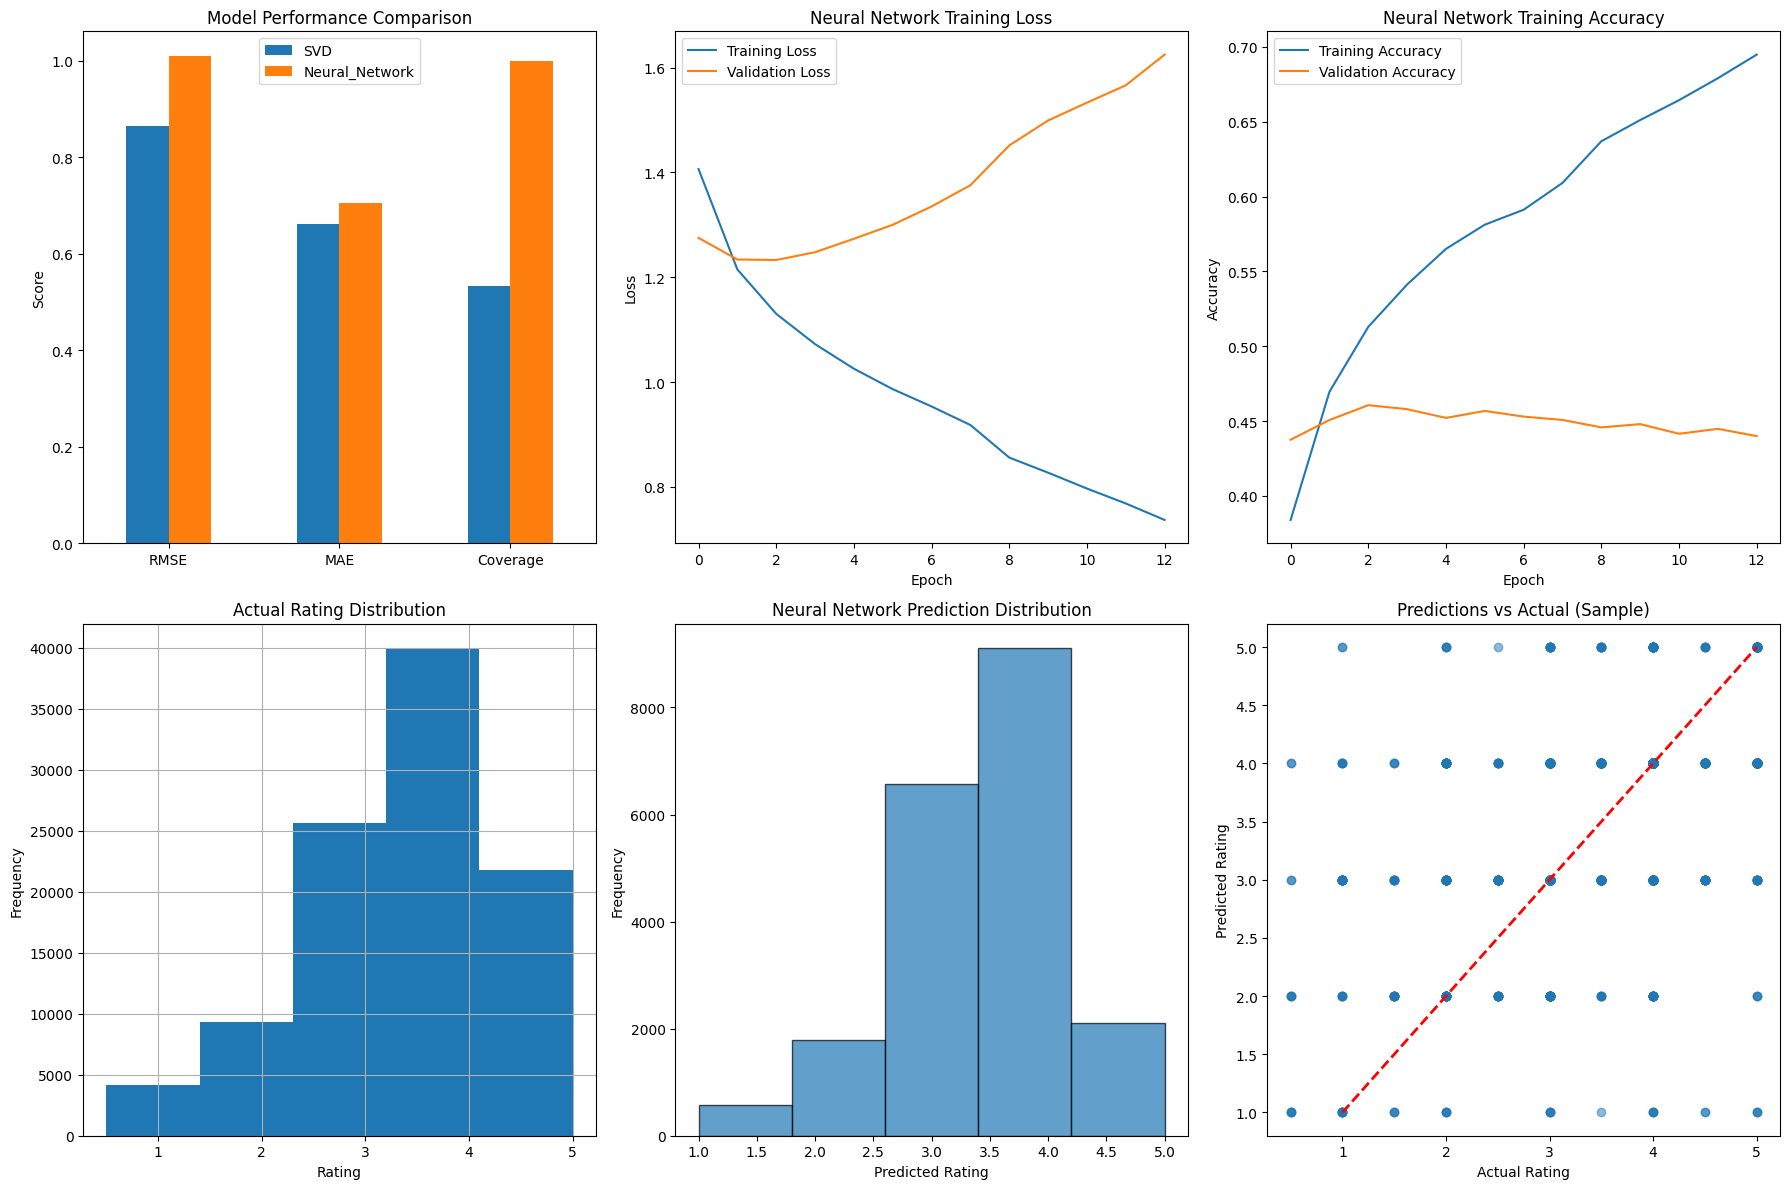

Best model: SVD
SVD RMSE: 0.8644
Neural Network RMSE: 1.0104


In [30]:
# Generate comprehensive plots
plot_comprehensive_results(comparison_df, history.history, neural_results)

print(f"Best model: {best_model_name}")
print(f"SVD RMSE: {svd_results['rmse']:.4f}")
print(f"Neural Network RMSE: {neural_results['rmse']:.4f}")

## 13. Evaluation of Recommender System

In [31]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

class ProperEvaluator:
    """Proper evaluation using train/test splits that gives meaningful metrics"""
    
    def __init__(self, ratings_df, movies_df):
        self.ratings_df = ratings_df
        self.movies_df = movies_df
    
    def create_user_splits(self, test_users, test_ratio=0.2):
        """Create train/test splits for each user"""
        user_splits = {}
        
        for user_id in test_users:
            user_ratings = self.ratings_df[self.ratings_df.userId == user_id]
            
            # Skip users with too few ratings
            if len(user_ratings) < 10:
                continue
            
            # Split user's ratings into train/test
            test_size = max(1, int(len(user_ratings) * test_ratio))
            test_indices = np.random.choice(user_ratings.index, test_size, replace=False)
            
            test_set = user_ratings.loc[test_indices]
            train_set = user_ratings.drop(test_indices)
            
            user_splits[user_id] = {
                'train': train_set,
                'test': test_set,
                'test_high_rated': test_set[test_set.rating >= 4.0]  # Relevant items
            }
        
        return user_splits
    
    def evaluate_svd_model(self, svd_model, user_splits, k_values=[5, 10]):
        """Evaluate SVD model using proper train/test methodology"""
        results = {
            'precision': {k: [] for k in k_values},
            'recall': {k: [] for k in k_values},
            'ndcg': {k: [] for k in k_values},
            'map': {k: [] for k in k_values},
            'rmse': [],
            'mae': []
        }
        
        valid_users = 0
        
        for user_id, splits in user_splits.items():
            test_set = splits['test']
            test_high_rated = splits['test_high_rated']
            
            # Skip if no relevant items in test set
            if len(test_high_rated) == 0:
                continue
                
            valid_users += 1
            
            # 1. Rating Prediction Accuracy
            predictions = []
            actuals = []
            
            for _, row in test_set.iterrows():
                try:
                    pred = svd_model.predict(user_id, row.movieId)
                    predictions.append(pred.est)
                    actuals.append(row.rating)
                except:
                    continue
            
            if len(predictions) > 0:
                rmse = np.sqrt(mean_squared_error(actuals, predictions))
                mae = mean_absolute_error(actuals, predictions)
                results['rmse'].append(rmse)
                results['mae'].append(mae)
            
            # 2. Ranking Quality
            # Get candidate movies (test movies that weren't in training)
            train_movies = set(splits['train'].movieId.tolist())
            test_movies = set(test_set.movieId.tolist())
            candidate_movies = list(test_movies)
            
            if len(candidate_movies) == 0:
                continue
            
            # Get predictions for candidate movies
            movie_predictions = []
            for movie_id in candidate_movies:
                try:
                    pred = svd_model.predict(user_id, movie_id)
                    movie_predictions.append((movie_id, pred.est))
                except:
                    continue
            
            # Sort by predicted rating
            movie_predictions.sort(key=lambda x: x[1], reverse=True)
            recommended_movies = [x[0] for x in movie_predictions]
            
            # Relevant items are those in test set with high ratings
            relevant_items = set(test_high_rated.movieId.tolist())
            
            # Calculate metrics for different k values
            for k in k_values:
                top_k_recs = set(recommended_movies[:k])
                
                # Precision@K
                precision = len(top_k_recs & relevant_items) / k if k > 0 else 0
                results['precision'][k].append(precision)
                
                # Recall@K  
                recall = len(top_k_recs & relevant_items) / len(relevant_items) if len(relevant_items) > 0 else 0
                results['recall'][k].append(recall)
                
                # NDCG@K
                ndcg = self.calculate_ndcg(recommended_movies[:k], relevant_items)
                results['ndcg'][k].append(ndcg)
                
                # MAP@K
                map_score = self.calculate_map(recommended_movies[:k], relevant_items)
                results['map'][k].append(map_score)
        
        # Calculate averages
        averaged_results = {}
        for metric in results:
            if metric in ['rmse', 'mae']:
                averaged_results[metric] = np.mean(results[metric]) if results[metric] else 0.0
            else:
                averaged_results[metric] = {k: np.mean(results[metric][k]) if results[metric][k] else 0.0 
                                          for k in k_values}
        
        averaged_results['model_type'] = 'SVD'
        averaged_results['valid_users'] = valid_users
        return averaged_results
    
    def evaluate_neural_model(self, neural_recommender, user_splits, k_values=[5, 10]):
        """Evaluate Neural Network model using proper train/test methodology"""
        results = {
            'precision': {k: [] for k in k_values},
            'recall': {k: [] for k in k_values},
            'ndcg': {k: [] for k in k_values},
            'map': {k: [] for k in k_values},
            'rmse': [],
            'mae': []
        }
        
        valid_users = 0
        
        for user_id, splits in user_splits.items():
            test_set = splits['test']
            test_high_rated = splits['test_high_rated']
            
            # Skip if no relevant items in test set
            if len(test_high_rated) == 0:
                continue
                
            valid_users += 1
            
            # 1. Rating Prediction Accuracy
            predictions = []
            actuals = []
            
            for _, row in test_set.iterrows():
                try:
                    pred_rating = neural_recommender.predict_rating(user_id, row.movieId)
                    predictions.append(pred_rating)
                    actuals.append(row.rating)
                except:
                    continue
            
            if len(predictions) > 0:
                rmse = np.sqrt(mean_squared_error(actuals, predictions))
                mae = mean_absolute_error(actuals, predictions)
                results['rmse'].append(rmse)
                results['mae'].append(mae)
            
            # 2. Ranking Quality
            # Get candidate movies (test movies)
            candidate_movies = list(test_set.movieId.tolist())
            
            if len(candidate_movies) == 0:
                continue
            
            # Get predictions for candidate movies
            movie_predictions = []
            for movie_id in candidate_movies:
                try:
                    pred_rating = neural_recommender.predict_rating(user_id, movie_id)
                    movie_predictions.append((movie_id, pred_rating))
                except:
                    continue
            
            # Sort by predicted rating
            movie_predictions.sort(key=lambda x: x[1], reverse=True)
            recommended_movies = [x[0] for x in movie_predictions]
            
            # Relevant items are those in test set with high ratings
            relevant_items = set(test_high_rated.movieId.tolist())
            
            # Calculate metrics for different k values
            for k in k_values:
                top_k_recs = set(recommended_movies[:k])
                
                # Precision@K
                precision = len(top_k_recs & relevant_items) / k if k > 0 else 0
                results['precision'][k].append(precision)
                
                # Recall@K  
                recall = len(top_k_recs & relevant_items) / len(relevant_items) if len(relevant_items) > 0 else 0
                results['recall'][k].append(recall)
                
                # NDCG@K
                ndcg = self.calculate_ndcg(recommended_movies[:k], relevant_items)
                results['ndcg'][k].append(ndcg)
                
                # MAP@K
                map_score = self.calculate_map(recommended_movies[:k], relevant_items)
                results['map'][k].append(map_score)
        
        # Calculate averages
        averaged_results = {}
        for metric in results:
            if metric in ['rmse', 'mae']:
                averaged_results[metric] = np.mean(results[metric]) if results[metric] else 0.0
            else:
                averaged_results[metric] = {k: np.mean(results[metric][k]) if results[metric][k] else 0.0 
                                          for k in k_values}
        
        averaged_results['model_type'] = 'Neural_Network'
        averaged_results['valid_users'] = valid_users
        return averaged_results
    
    def calculate_ndcg(self, recommended, relevant, k=None):
        """Calculate NDCG"""
        if k is not None:
            recommended = recommended[:k]
        
        relevances = [1 if item in relevant else 0 for item in recommended]
        
        # DCG
        dcg = relevances[0] if len(relevances) > 0 else 0
        for i in range(1, len(relevances)):
            dcg += relevances[i] / math.log2(i + 1)
        
        # IDCG
        ideal_relevances = [1] * min(len(relevant), len(recommended))
        idcg = ideal_relevances[0] if len(ideal_relevances) > 0 else 0
        for i in range(1, len(ideal_relevances)):
            idcg += ideal_relevances[i] / math.log2(i + 1)
        
        return dcg / idcg if idcg > 0 else 0.0
    
    def calculate_map(self, recommended, relevant):
        """Calculate Mean Average Precision"""
        if len(relevant) == 0:
            return 0.0
        
        precisions = []
        num_hits = 0
        
        for i, item in enumerate(recommended):
            if item in relevant:
                num_hits += 1
                precisions.append(num_hits / (i + 1))
        
        return sum(precisions) / len(relevant) if len(precisions) > 0 else 0.0


In [32]:
# Comprehensive evaluation function
def comprehensive_evaluation():
    """Run comprehensive evaluation with meaningful metrics"""
    print("\n=== COMPREHENSIVE MODEL EVALUATION ===")
    
    # Get test users with sufficient ratings
    users_with_many_ratings = ratings_df.groupby('userId').size()
    test_users = users_with_many_ratings[users_with_many_ratings >= 15].index.tolist()[:25]
    
    print(f"Evaluating on {len(test_users)} users with 15+ ratings...")
    
    # Create evaluator and user splits
    evaluator = ProperEvaluator(ratings_df, movies_df)
    user_splits = evaluator.create_user_splits(test_users, test_ratio=0.3)
    
    print(f"Evaluating SVD model...")
    svd_results = evaluator.evaluate_svd_model(best_svd, user_splits)
    
    print(f"Evaluating Neural Network model...")
    neural_results = evaluator.evaluate_neural_model(neural_recommender, user_splits)
    
    # Display results
    print(f"\n=== COMPREHENSIVE METRICS COMPARISON ===")
    
    # Create comparison table
    metrics_df = pd.DataFrame({
        'SVD': [
            svd_results['rmse'],
            svd_results['mae'],
            svd_results['precision'][10],
            svd_results['recall'][10],
            svd_results['ndcg'][10],
            svd_results['map'][10]
        ],
        'Neural_Network': [
            neural_results['rmse'],
            neural_results['mae'],
            neural_results['precision'][10],
            neural_results['recall'][10],
            neural_results['ndcg'][10],
            neural_results['map'][10]
        ]
    }, index=['RMSE', 'MAE', 'Precision@10', 'Recall@10', 'NDCG@10', 'MAP@10'])
    
    print(metrics_df.round(4))
    
    print(f"\n=== DETAILED RANKING METRICS ===")
    for k in [5, 10]:
        print(f"\nMetrics @{k}:")
        print(f"           SVD    Neural")
        print(f"Precision: {svd_results['precision'][k]:.3f}   {neural_results['precision'][k]:.3f}")
        print(f"Recall:    {svd_results['recall'][k]:.3f}   {neural_results['recall'][k]:.3f}")
        print(f"NDCG:      {svd_results['ndcg'][k]:.3f}   {neural_results['ndcg'][k]:.3f}")
        print(f"MAP:       {svd_results['map'][k]:.3f}   {neural_results['map'][k]:.3f}")
    
    print(f"\nValid users: SVD={svd_results['valid_users']}, Neural={neural_results['valid_users']}")
    
    # Determine winner
    if svd_results['ndcg'][10] > neural_results['ndcg'][10]:
        winner = "SVD"
    elif neural_results['ndcg'][10] > svd_results['ndcg'][10]:
        winner = "Neural Network"
    else:
        winner = "Tie"
    
    print(f"\nOverall ranking quality winner (NDCG@10): {winner}")
    
    return svd_results, neural_results, metrics_df

In [33]:
# Execute comprehensive evaluation
print("Starting comprehensive evaluation with meaningful metrics...")
comprehensive_svd_results, comprehensive_neural_results, comprehensive_metrics_df = comprehensive_evaluation()

Starting comprehensive evaluation with meaningful metrics...

=== COMPREHENSIVE MODEL EVALUATION ===
Evaluating on 25 users with 15+ ratings...
Evaluating SVD model...
Evaluating Neural Network model...

=== COMPREHENSIVE METRICS COMPARISON ===
                 SVD  Neural_Network
RMSE          0.5351          0.8749
MAE           0.3908          0.7243
Precision@10  0.8280          0.6480
Recall@10     0.6258          0.5278
NDCG@10       0.9607          0.7626
MAP@10        0.6080          0.4400

=== DETAILED RANKING METRICS ===

Metrics @5:
           SVD    Neural
Precision: 0.952   0.736
Recall:    0.424   0.340
NDCG:      0.963   0.757
MAP:       0.414   0.297

Metrics @10:
           SVD    Neural
Precision: 0.828   0.648
Recall:    0.626   0.528
NDCG:      0.961   0.763
MAP:       0.608   0.440

Valid users: SVD=25, Neural=25

Overall ranking quality winner (NDCG@10): SVD
